In [1]:
#dl.ipynb
#
#by Joe Hahn
#jmh.datasciences@gmail.com
#24 January 2018

In [2]:
#import matplotlib pandas etc
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
from matplotlib import rcParams
sns.set(font_scale=1.5, font='DejaVu Sans')
pd.set_option('display.max_columns', None)
pd.set_option('display.height', None)
pd.set_option('display.width', None)

height has been deprecated.



In [3]:
#read books dataframe
import pickle
with open('chunks.pkl', 'rb') as fp:
    chunks = pickle.load(fp)
print 'number of records = ', len(chunks)
chunks.head()

number of records =  249870


,author,title,input_file,text_chunk
5732,Macaulay,Critical & Historical Essays,iso/etext00/1cahe10.txt,"tribunal. The London juries, he said, entertai..."
5733,Macaulay,Critical & Historical Essays,iso/etext00/1cahe10.txt,"devils as there were tiles on the houses, or l..."
5734,Macaulay,Critical & Historical Essays,iso/etext00/1cahe10.txt,"indeed be, if we were to suppose that the nati..."
5735,Macaulay,Critical & Historical Essays,iso/etext00/1cahe10.txt,"reign of Elizabeth, the people were in a state..."
5736,Macaulay,Critical & Historical Essays,iso/etext00/1cahe10.txt,"Queen of Scotland, the hostility of Philip, ex..."


In [4]:
#apply some manual fixes to the some improperly parsed authors and titles
idx = chunks['author'].str.contains('Proudhon')
chunks.loc[idx, 'author'] = 'Proudhon'
idx = chunks['author'].str.contains('Homer')
chunks.loc[idx, 'author'] = 'Homer'
idx = chunks['author'].str.contains('Wake, Entire')
chunks.loc[idx, 'author'] = 'Archbishop Wake'
chunks.loc[idx, 'title'] = 'Forbidden Gospels and Epistles, Complete'
idx = chunks['title'].str.contains('War And Peace')
chunks.loc[idx, 'author'] = 'Leo Tolstoy'
idx = chunks['title'].str.contains('Nicholas Nickle')
chunks.loc[idx, 'title'] = 'Nicholas Nickleby'
chunks.loc[idx, 'author'] = 'Dickens'
idx = chunks['author'].str.contains('Dick,')
chunks.loc[idx, 'title'] = 'Moby Dick'
chunks.loc[idx, 'author'] = 'Herman Melville'
idx = (chunks['author'] == 'Sshe')
chunks.loc[idx, 'author'] = 'Percy Bysshe Shelley'
chunks.loc[idx, 'title'] = 'The Complete Poetical Works of Percy Bysshe'
idx = chunks['author'].str.contains('Maupassant')
chunks.loc[idx, 'author'] = 'Maupassant'
idx = chunks['author'].str.contains('Dumas')
chunks.loc[idx, 'author'] = 'Dumas'
idx = chunks['author'].str.contains('Constant')
chunks.loc[idx, 'author'] = 'Constant'
idx = chunks['title'].str.contains('Supplemental Nights')
chunks.loc[idx, 'author'] = 'Sir Richard Francis Burton'
idx = chunks['title'].str.contains("Plutarch'S Lives")
chunks.loc[idx, 'title'] = "Plutarch's Lives"
idx = chunks['author'].str.contains("Xenophon")
chunks.loc[idx, 'author'] = "Xenophon"

In [5]:
#count number of chunks each book has, and cumulative sum
count = pd.DataFrame(chunks.groupby('input_file')['title'].count().sort_values())
count.columns = ['chunk_count']
count['cumulative_sum'] = count['chunk_count'].cumsum()
count['cumulative_sum'] /= count['cumulative_sum'].max()
count = count.reset_index(level=0)
count.head()

,input_file,chunk_count,cumulative_sum
0,iso/etext98/2ws2710.txt,17,0.000068
1,iso/etext98/2ws4510.txt,25,0.000168
2,iso/etext98/2ws4410.txt,32,0.000296
3,iso/etext03/fgths10.txt,34,0.000432
4,iso/etext97/mdprp10.txt,37,0.000580


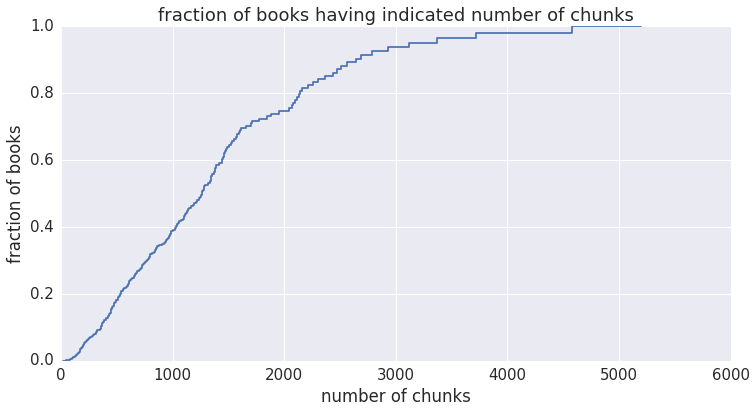

In [6]:
#plot cumulative sum of chunk counts
fig, ax = plt.subplots(figsize=(12, 6))
xp = count['chunk_count']
yp = count['cumulative_sum']
p = ax.plot(xp, yp, drawstyle='steps-mid')
p = ax.set_xlabel('number of chunks')
p = ax.set_ylabel('fraction of books')
p = ax.set_title('fraction of books having indicated number of chunks')
plt.savefig('figs/chunks.png')

In [7]:
#preserve records associated with books having 750+ chunks
chunks_counted = chunks.merge(count, on='input_file', how='inner')
idx = chunks_counted['chunk_count'] > 750
chunks_counted = chunks_counted[idx]
print 'number of records = ', len(chunks_counted)
chunks_counted.head()

number of records =  176706


,author,title,input_file,text_chunk,chunk_count,cumulative_sum
0,Macaulay,Critical & Historical Essays,iso/etext00/1cahe10.txt,"tribunal. The London juries, he said, entertai...",2075,0.762961
1,Macaulay,Critical & Historical Essays,iso/etext00/1cahe10.txt,"devils as there were tiles on the houses, or l...",2075,0.762961
2,Macaulay,Critical & Historical Essays,iso/etext00/1cahe10.txt,"indeed be, if we were to suppose that the nati...",2075,0.762961
3,Macaulay,Critical & Historical Essays,iso/etext00/1cahe10.txt,"reign of Elizabeth, the people were in a state...",2075,0.762961
4,Macaulay,Critical & Historical Essays,iso/etext00/1cahe10.txt,"Queen of Scotland, the hostility of Philip, ex...",2075,0.762961


In [8]:
#loop over each input_file and preserve random sample of each book's chunks, up to 2200
chunks_sampled = pd.DataFrame()
input_files = chunks_counted['input_file'].unique()
for input_file in input_files: 
    idx = (chunks_counted['input_file'] == input_file)
    df = chunks_counted[idx]
    Ns = len(df)
    if (Ns > 2200):
        df = df.sample(2200)
    chunks_sampled = chunks_sampled.append(df, ignore_index=True)
print 'number of records = ', len(chunks_sampled)
chunks_sampled.head()

number of records =  165450


,author,title,input_file,text_chunk,chunk_count,cumulative_sum
0,Macaulay,Critical & Historical Essays,iso/etext00/1cahe10.txt,"tribunal. The London juries, he said, entertai...",2075,0.762961
1,Macaulay,Critical & Historical Essays,iso/etext00/1cahe10.txt,"devils as there were tiles on the houses, or l...",2075,0.762961
2,Macaulay,Critical & Historical Essays,iso/etext00/1cahe10.txt,"indeed be, if we were to suppose that the nati...",2075,0.762961
3,Macaulay,Critical & Historical Essays,iso/etext00/1cahe10.txt,"reign of Elizabeth, the people were in a state...",2075,0.762961
4,Macaulay,Critical & Historical Essays,iso/etext00/1cahe10.txt,"Queen of Scotland, the hostility of Philip, ex...",2075,0.762961


In [9]:
#confirm that book contribute 750 to 2200 chunks
N_chunks = pd.DataFrame(chunks_sampled.groupby('input_file')['input_file'].count())
N_chunks.columns = ['chunk_count']
N_chunks = N_chunks.reset_index(level=0)
cols = [u'author', u'title', u'input_file', u'text_chunk']
chunks_recounted = chunks_sampled[cols].merge(N_chunks, on='input_file', how='inner')
cols = [u'author', u'title', u'input_file', 'chunk_count', u'text_chunk']
print chunks_recounted['chunk_count'].min(), chunks_recounted['chunk_count'].max()
print 'number of records = ', len(chunks_recounted)
chunks_recounted.head()

757 2200
number of records =  165450


,author,title,input_file,text_chunk,chunk_count
0,Macaulay,Critical & Historical Essays,iso/etext00/1cahe10.txt,"tribunal. The London juries, he said, entertai...",2075
1,Macaulay,Critical & Historical Essays,iso/etext00/1cahe10.txt,"devils as there were tiles on the houses, or l...",2075
2,Macaulay,Critical & Historical Essays,iso/etext00/1cahe10.txt,"indeed be, if we were to suppose that the nati...",2075
3,Macaulay,Critical & Historical Essays,iso/etext00/1cahe10.txt,"reign of Elizabeth, the people were in a state...",2075
4,Macaulay,Critical & Historical Essays,iso/etext00/1cahe10.txt,"Queen of Scotland, the hostility of Philip, ex...",2075


In [10]:
#for multi-book authors, drop all but the title having the most chunks, and add author_id
N = pd.DataFrame(chunks_recounted.groupby(['author', 'title', 'input_file'])['text_chunk'].count()).reset_index()
N = N.sort_values(['author', 'text_chunk'], ascending=False).drop_duplicates(['author'])
N = N.sort_values('author')
N['author_id'] = N.index
print 'number of books = ', len(N)
N.head()

number of books =  90


,author,title,input_file,text_chunk,author_id
0,A.H. Clough,Plutarch's Lives,iso/etext96/plivs10.txt,2200,0
1,Adam Smith,Wealth Of Nations,iso/etext02/wltnt10.txt,2200,1
2,Adams,The Education Of Henry Adams,iso/etext00/eduha10.txt,1260,2
3,Anne C. Lynch Botta,Handbook Of Universal Literature,iso/etext05/8unlt10.txt,1699,3
6,Anthony Trollope,The Last Chronicle Of Barset,iso/etext02/lacob11.txt,2200,6


In [11]:
#join chunks_recounted to N to preserve the desired books, and randomize records
cols = ['author', 'author_id', 'title', 'input_file', 'text_chunk']
chunks_filtered = chunks_recounted.merge(N[['input_file', 'author_id']], on='input_file', how='inner')[cols]
chunks_filtered = chunks_filtered.sample(frac=1)[cols]
print 'number of records = ', len(chunks_filtered)
chunks_filtered.head()

number of records =  128314


,author,author_id,title,input_file,text_chunk
110196,Dickens,31,Nicholas Nickleby,iso/etext97/ncklb10.txt,disappointed he couldn't have written about bl...
48039,Various,113,The Junior Classics,iso/etext04/8jrc710.txt,"the sight to bear upon the pigeon, I pulled tr..."
65662,Thomas D'Arcy Mcgee,107,A Popular History Of Ireland,iso/etext04/phrlc10.txt,pay; but though De Ginkle was most eager to se...
63884,Samuel Richardson,95,Pamela,iso/etext04/pam1w10.txt,may keep my hands to myself. I don't say it to...
98291,George Borrow,45,The Bible In Spain,iso/etext96/tbisp10.txt,though there were two or three of us at hand t...


In [12]:
#check the above
N = pd.DataFrame(chunks_filtered.groupby(['author', 'title', 'input_file'])['text_chunk'].count())\
    .reset_index().sort_values('author')
print 'number of books = ', len(N)
N.head()

number of books =  90


,author,title,input_file,text_chunk
0,A.H. Clough,Plutarch's Lives,iso/etext96/plivs10.txt,2200
1,Adam Smith,Wealth Of Nations,iso/etext02/wltnt10.txt,2200
2,Adams,The Education Of Henry Adams,iso/etext00/eduha10.txt,1260
3,Anne C. Lynch Botta,Handbook Of Universal Literature,iso/etext05/8unlt10.txt,1699
4,Anthony Trollope,The Last Chronicle Of Barset,iso/etext02/lacob11.txt,2200


In [13]:
#train-test-validate split
train_size = 0.5
validate_size=0.4   #this is the fraction of the test sample that is assigned to the validation sample
rn_seed = 23
from sklearn.model_selection import train_test_split
train, test = train_test_split(chunks_filtered, train_size=train_size, random_state=rn_seed)
validate, test = train_test_split(test, train_size=validate_size, random_state=rn_seed)
print 'chunks_filtered.shape = ', chunks_filtered.shape
print 'train.shape            = ', train.shape
print 'test.shape             = ', test.shape
print 'validate.shape         = ', validate.shape

chunks_filtered.shape =  (128314, 5)
train.shape            =  (64157, 5)
test.shape             =  (38495, 5)
validate.shape         =  (25662, 5)


In [15]:
#count word frequencies
from collections import defaultdict
word_frequency = defaultdict(int)
corpus = chunks_filtered['text_chunk'].tolist()
for doc in corpus:
    words = doc.split(' ')
    for word in words:
        word_frequency[word] += 1
print 'number of distinct words = ', len(word_frequency.keys()) 
for word in word_frequency.keys()[1:7]:
    print word, word_frequency[word]

number of distinct words =  474495
lenitives 2
_Lyrical 1
young--it's 1
woods 318
Catalans. 2
spiders 22


In [16]:
#generate tokenizer
vocabulary_size = 1000
N_inputs = 100
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words=vocabulary_size)

Using TensorFlow backend.


In [17]:
#tokenize corpus of training documents to get training x,y
df = train
corpus = df['text_chunk'].tolist()
tokenizer.fit_on_texts(corpus)
corpus_tokenized = tokenizer.texts_to_sequences(corpus)
corpus_padded = pad_sequences(corpus_tokenized, maxlen=N_inputs)
x_train = np.array(corpus_padded)
y_train = df['author_id'].values
N_outputs = len(np.unique(y_train))
print 'x_train.shape = ', x_train.shape
print 'y_train.shape = ', y_train.shape
print 'N_inputs = ', N_inputs
print 'N_outputs = ', N_outputs

x_train.shape =  (64157, 100)
y_train.shape =  (64157,)
N_inputs =  100
N_outputs =  90


In [18]:
print x_train[123]
print y_train[123]

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0 529 848  33   1 124   6 474 295 223   1   9   1
 255  12 245 159   4  34 201 178 700   2   5 372  68 189  22  14  94  37
   6  34   4  21 629  69   7   1 195 104  48  21 145 133   5  74   4  14
  51  10  44 151   4  22  41  63 144   5  41 587  25 338  88 708  41  36
  55   6   1   3   1 848   2  13   4  21]
25


In [19]:
#tokenize validation documents to get validation x,y
df = validate
corpus = df['text_chunk'].tolist()
corpus_tokenized = tokenizer.texts_to_sequences(corpus)
corpus_padded = pad_sequences(corpus_tokenized, maxlen=N_inputs)
x_validate = np.array(corpus_padded)
y_validate = df['author_id'].values
print 'x_validate.shape = ', x_validate.shape
print 'y_validate.shape = ', y_validate.shape
print 'N_inputs = ', N_inputs

x_validate.shape =  (25662, 100)
y_validate.shape =  (25662,)
N_inputs =  100


In [20]:
print x_validate[123]
print y_validate[123]

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   2  20   3   2   6   5 220 258   1 119 115  32   1
   2 963  15   1 287 935  13   1 400   3  72   2 263  20 164   2  88 391
   1 165 120  24   1 156  25  43  17  53   5 183   3  20  59  20   2 214
 712 285  24   1   3 897 164   1  25  72 110 189 146  25   6   1 446 124
   1  22 630 504   1  17 330 164  19   1]
25


In [23]:
#build LSTM model...this one is adapted from 
#http://www.developintelligence.com/blog/2017/06/practical-neural-networks-keras-classifying-yelp-reviews/
from keras.layers import Embedding, LSTM, Dense, Dropout#, Conv1D, MaxPooling1D, Activation
from keras.models import Sequential
model = Sequential()
embedding_vector_length = 32
model.add(Embedding(vocabulary_size, embedding_vector_length, input_length=N_inputs))
model.add(LSTM(embedding_vector_length, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(N_outputs, activation='softmax'))
loss_fn = 'categorical_crossentropy'
#loss_fn = 'sparse_categorical_crossentropy'
model.compile(loss=loss_fn, optimizer='adam', metrics=['accuracy'])

In [24]:
#fit the model to the training data
N_training_epochs = 1
loss_history = model.fit(x_train, y_train, epochs=N_training_epochs, batch_size=64, verbose=1)#, \
#    validation_data=(x_validate, y_validate))
Embedding?

ValueError: Error when checking target: expected dense_2 to have shape (None, 90) but got array with shape (64157, 1)

In [ ]:
#tokenize test documents to get testing x,y
df = test
corpus = df['text_chunk'].tolist()
corpus_tokenized = tokenizer.texts_to_sequences(corpus)
corpus_padded = pad_sequences(corpus_tokenized, maxlen=N_inputs)
x_test = np.array(corpus_padded)
y_test = df['author_id'].values
print 'x_test.shape = ', x_test.shape
print 'y_test.shape = ', y_test.shape
print 'N_inputs = ', N_inputs

In [ ]:
#generate predicted y_test 
#col = target_col + '_pred'
y_test_pred = model.predict(x_test)
#y_test_pred = pd.DataFrame(model.predict(x_test), index=index[test_idx], columns=[col])
#print x_test.shape, y_test.shape
#y_test_pred.head()

In [ ]:
y_test_pred